This example shows a VNA-like functionality using 1 signal generator and 1 readout block.

In [1]:
import sys
# sys.path.append('../qick/qick_lib/')
sys.path.append('soft/')

from qick import *
from qick_training import *

from qick.averager_program import QickSweep
from qick.averager_program import QickRegister
from qick.averager_program import merge_sweeps

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift
from tqdm.notebook import tqdm

In [2]:
# Initialize Firmware.
soc = QickTrainingSoc('./qick_training.bit')

# Print information.
soccfg = soc
print(soc)


QICK configuration:

	Board: ZCU208

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	6 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, blk 0, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, blk 1, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, blk 2, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, blk 3, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=307.200 MHz, f_dds=4915.200 MHz
	5:	axis_sg_mux4_v1 - tProc output 6, envelope memory 0 samples
		DAC tile 0, blk 0, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz

	8 readout channels:
	0:	axis_pf

In [3]:
######################################
### Build Resonator Emulator Chain ###
######################################
simu = SimuChain(soc,soc['simu'][0], name="226_2 <-> 229_0")

In [37]:
###############################
### Resonator Configuration ###
###############################
simu.qout(3)
simu.synthesis.qout(1)

# Disable all resonators.
simu.alloff()

# Enable resonator.
simu.enable(499.3)
#simu.enable(503)
#simu.enable(800)
#simu.enable(1105)

#simu.disable(595)
#simu.disable(600)
#simu.disable(605)

In [38]:
class VnaProgram(NDAveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=1)
                        
        # First channel.
        length   = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch'])
        freq_gen = self.freq2reg(self.cfg['pulse_freq'],gen_ch=self.cfg['gen_ch'],ro_ch=self.cfg['ro_ch'])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'],
                                     style  = 'const',
                                     length = length,
                                     freq   = freq_gen,
                                     phase  = 0,
                                     gain   = self.cfg['pulse_gain'])
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch']),
                             freq    = self.cfg['pulse_freq'],
                             sel     = self.cfg['ro_sel'],
                             gen_ch  = self.cfg['gen_ch'])
        
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'], phrst=0, mode="oneshot")
        
        self.synci(200)  # give processor some time to configure pulses      
    
    def body(self):

        self.measure(pulse_ch        = self.cfg['gen_ch'], 
                     adcs            = self.ro_chs,
                     pins            = [0], 
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch']),
                     )
        
config={"gen_ch"      : 4,
        "reps"        : 1,
        "pulse_length": 25,
        "pulse_gain"  : 8000, # [DAC units]
        "pulse_freq"  : 498.5, # [MHz]
       }

ro_cfg = {
    "ro_ch"     : 4,
    "ro_length" : 5,
    "ro_sel"    : 'product',
    "ro_offset" : 10,
    "soft_avgs" : 1
}

config.update(**ro_cfg)

prog = VnaProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)

  0%|          | 0/1 [00:00<?, ?it/s]

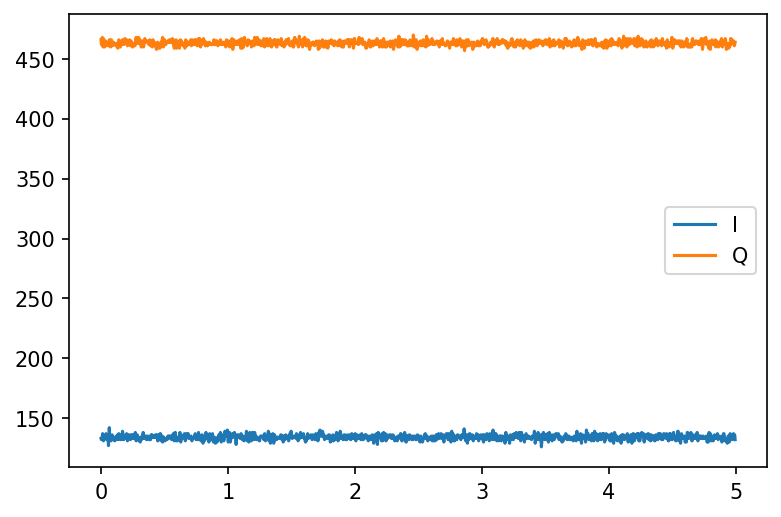

In [39]:
plt.figure(dpi=150)

# Time index.
iq = iq_list[0]
t = soccfg.cycles2us(np.arange(len(iq_list[0])), ro_ch=config['ro_ch'])
n=range(len(iq_list[0]))
plt.plot(t, iq[:,0], label='I')
plt.plot(t, iq[:,1], label='Q')
plt.legend();

In [40]:
def phase_correction(f, phi, DT = 20):
    # Unwrap phase.
    phi_u = np.unwrap(phi)
    phi_u = phi_u - phi_u[0]

    # Phase correction by delay DT.
    # phi_u = 2*pi*f*(DT + dt)
    # phi_u = 2*pi*f*DT + 2*pi*f*dt = phi_DT + phi_dt
    # phi_dt = phi_u - 2*pi*f*DT
    phi_dt = phi_u - 2*np.pi*f*DT
    phi_dt = phi_dt - phi_dt[0]

    return phi_u, phi_dt

def phase_fit(f, phi):
    # Dictionary for output data.
    data = {}
    data['fits'] = []

    coef   = np.polyfit(f,phi, 1)
    fit_fn = np.poly1d(coef)

    fit_ = {'slope' : coef[0], 'data' : {'x' : f, 'y' : phi, 'fn' : fit_fn(f)}}
    data['fits'].append(fit_)

    return data

Sweep Parameters
* fstart = 489.3 MHz
* fstop  = 509.3 MHz
* N      = 1500
* fr     = 0.013342228152112057 MHz


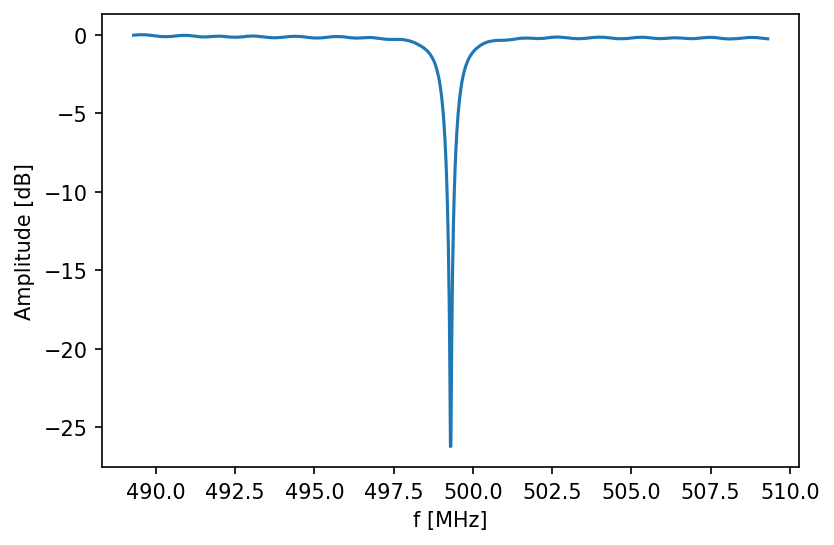

In [41]:
# Frequency sweep.
fc = 499.3
df = 20
fstart = fc - df/2
fstop = fc + df/2
N = 1500
freqs = np.linspace(start=fstart, stop=fstop, num=N)
print('Sweep Parameters')
print('* fstart = {} MHz'.format(fstart))
print('* fstop  = {} MHz'.format(fstop))
print('* N      = {}'.format(N))
print('* fr     = {} MHz'.format(freqs[1]-freqs[0]))

xi_v = np.zeros(len(freqs))
xq_v = np.zeros(len(freqs))
for i,f in enumerate(freqs):
    config['pulse_freq'] = f

    prog = VnaProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    xi,xq = res[1].item(),res[2].item()
    
    xi_v[i] = xi
    xq_v[i] = xq
    
x = xi_v + 1j*xq_v
a = np.abs(x)
phi = np.angle(x)

#############
### Plots ###
#############
plt.figure(dpi=150)
plt.plot(freqs,20*np.log10(a/np.max(a)))
plt.xlabel('f [MHz]')
plt.ylabel('Amplitude [dB]');

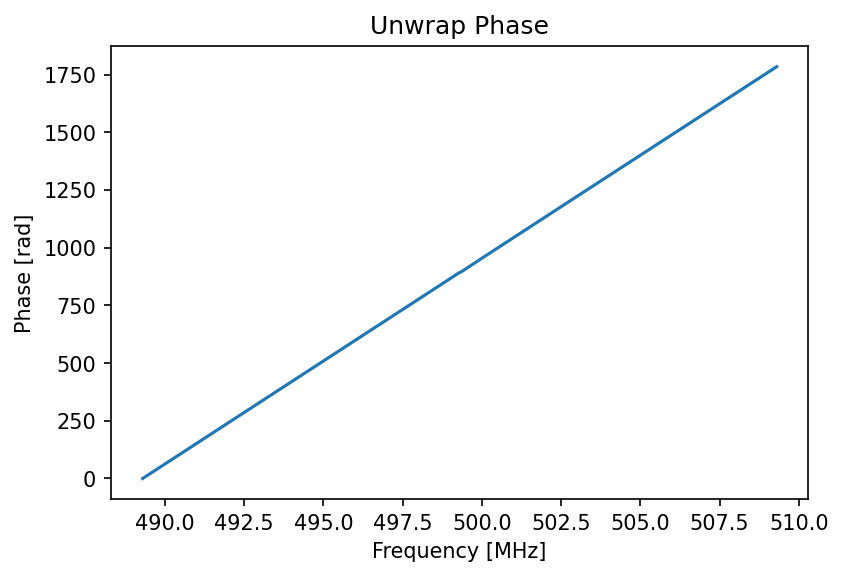

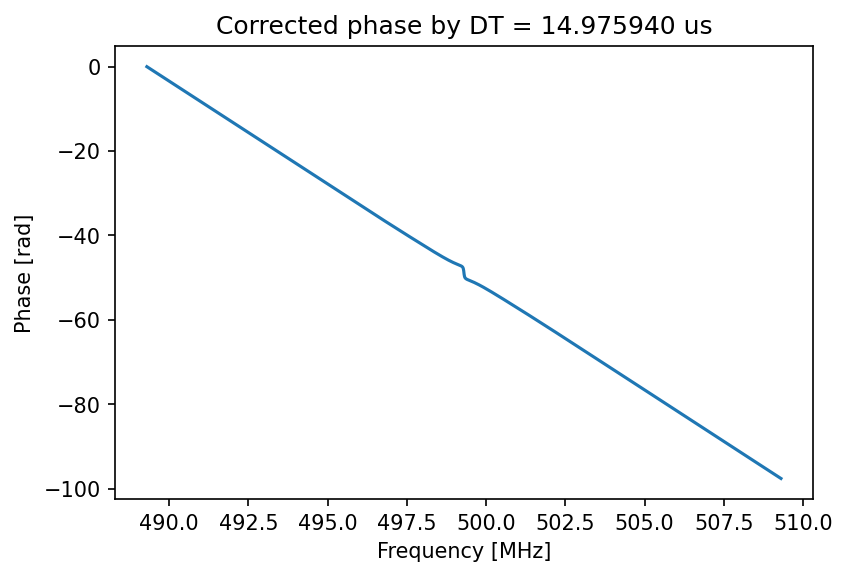

In [42]:
##############################
### Phase Correction by DT ###
##############################
# DT is in us.
DT = 14.9+0.07594

phi_u, phi_dt = phase_correction(freqs, phi, DT=DT)

#plt.figure(dpi=150)
#plt.plot(freqs,phi)
#plt.xlabel("Frequency [MHz]");
#plt.ylabel("Phase [rad]");
#plt.title("Original Phase");

plt.figure(dpi=150)
plt.plot(freqs,phi_u)
plt.xlabel("Frequency [MHz]");
plt.ylabel("Phase [rad]");
plt.title("Unwrap Phase");

plt.figure(dpi=150)
plt.plot(freqs,phi_dt)
plt.xlabel("Frequency [MHz]");
plt.ylabel("Phase [rad]");
plt.title("Corrected phase by DT = {:.6f} us".format(DT));

Slope = = -0.7768605194752035 us


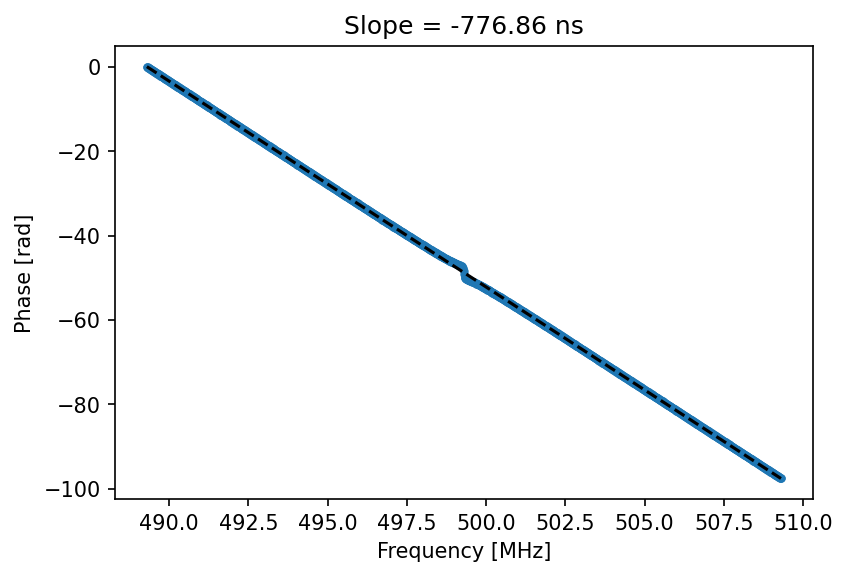

In [43]:
#################################
### Overall delay computation ###
#################################
data = phase_fit(freqs, phi_dt)

m = data['fits'][0]['slope']
x = data['fits'][0]['data']['x']
y = data['fits'][0]['data']['y']
fn = data['fits'][0]['data']['fn']
    
print("Slope = = {} us".format(m/(2*np.pi)))
plt.figure(dpi=150);
plt.plot(x, y, '.', x, fn, '--k');
plt.xlabel("Frequency [MHz]");
plt.ylabel("Phase [rad]");
plt.title("Slope = {:.5} ns".format(1000*m/(2*np.pi)));
#plt.savefig('phase-slope-2.jpg')

In [44]:
1/DT/2

0.033386885898314234